In [5]:
import requests
import pandas as pd
import time

# Lista de las tres criptomonedas principales
cryptos = [
    {"id": "bitcoin", "name": "Bitcoin"},
    {"id": "ethereum", "name": "Ethereum"},
    {"id": "litecoin", "name": "Litecoin"}
]

vs_currency = "usd"
days = 120

# Lista para almacenar los DataFrames
crypto_dfs = []

# Iterar sobre cada criptomoneda y obtener los datos
for crypto in cryptos:
    api_url = f"https://api.coingecko.com/api/v3/coins/{crypto['id']}/market_chart"
    params = {"vs_currency": vs_currency, "days": days}
    
    # Solicitar datos de la API
    response = requests.get(api_url, params=params)
    data = response.json()

    # Verificar si la respuesta contiene la clave 'prices'
    if "prices" in data:
        prices = data["prices"]
        df = pd.DataFrame(prices, columns=["timestamp", "price"])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df['id'] = range(1, len(df) + 1)
        df['date'] = df['timestamp'].dt.date
        df['daily_change'] = df['price'].pct_change() * 100
        df['moving_average_7'] = df['price'].rolling(window=7).mean()
        df['max_price_value'] = df['price'].rolling(window=7, min_periods=1).max()
        df['min_price_value'] = df['price'].rolling(window=7, min_periods=1).min()
        
        # Definir los percentiles para las categorías de precio
        percentiles = df['price'].quantile([0.2, 0.4, 0.6, 0.8]).values
        bins = [df['price'].min()] + percentiles.tolist() + [df['price'].max()]
        labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
        df['price_category'] = pd.cut(df['price'], bins=bins, labels=labels, include_lowest=True)

        # Desglosar la columna 'timestamp' en nuevas columnas
        df['year'] = df['timestamp'].dt.year
        df['month'] = df['timestamp'].dt.month
        df['day'] = df['timestamp'].dt.day
        df['hour'] = df['timestamp'].dt.hour

        # Calcular la columna 'valley'
        df['valley'] = ((df['price'] < df['price'].shift(1)) & (df['price'] < df['price'].shift(-1))).astype(int)

        # Añadir columna de criptomoneda
        df['crypto'] = crypto['name']

        # Añadir el DataFrame a la lista
        crypto_dfs.append(df)
    else:
        # Imprimir la respuesta completa para depuración
        print(f"Error: No se encontraron precios para {crypto['name']}")
        print("Respuesta de la API:", data)

    # Pausar entre solicitudes para evitar superar el límite de tasa
    time.sleep(5)

# Combinar todos los DataFrames en uno solo si no hubo errores
if crypto_dfs:
    final_df = pd.concat(crypto_dfs, ignore_index=True)
    print(final_df)
else:
    print("No se pudo crear el DataFrame final debido a errores con las respuestas de la API.")


              timestamp         price   id        date  daily_change  \
0   2024-06-27 00:00:00  60749.896194    1  2024-06-27           NaN   
1   2024-06-28 00:00:00  61562.645326    2  2024-06-28      1.337861   
2   2024-06-29 00:00:00  60317.096979    3  2024-06-29     -2.023221   
3   2024-06-30 00:00:00  60864.443162    4  2024-06-30      0.907448   
4   2024-07-01 00:00:00  62734.393839    5  2024-07-01      3.072320   
..                  ...           ...  ...         ...           ...   
358 2024-10-21 00:00:00     74.181934  117  2024-10-21     -0.904433   
359 2024-10-22 00:00:00     70.729472  118  2024-10-22     -4.654047   
360 2024-10-23 00:00:00     69.840098  119  2024-10-23     -1.257431   
361 2024-10-24 00:00:00     70.067453  120  2024-10-24      0.325537   
362 2024-10-24 22:29:39     70.782480  121  2024-10-24      1.020483   

     moving_average_7  max_price_value  min_price_value price_category  year  \
0                 NaN     60749.896194     60749.896194

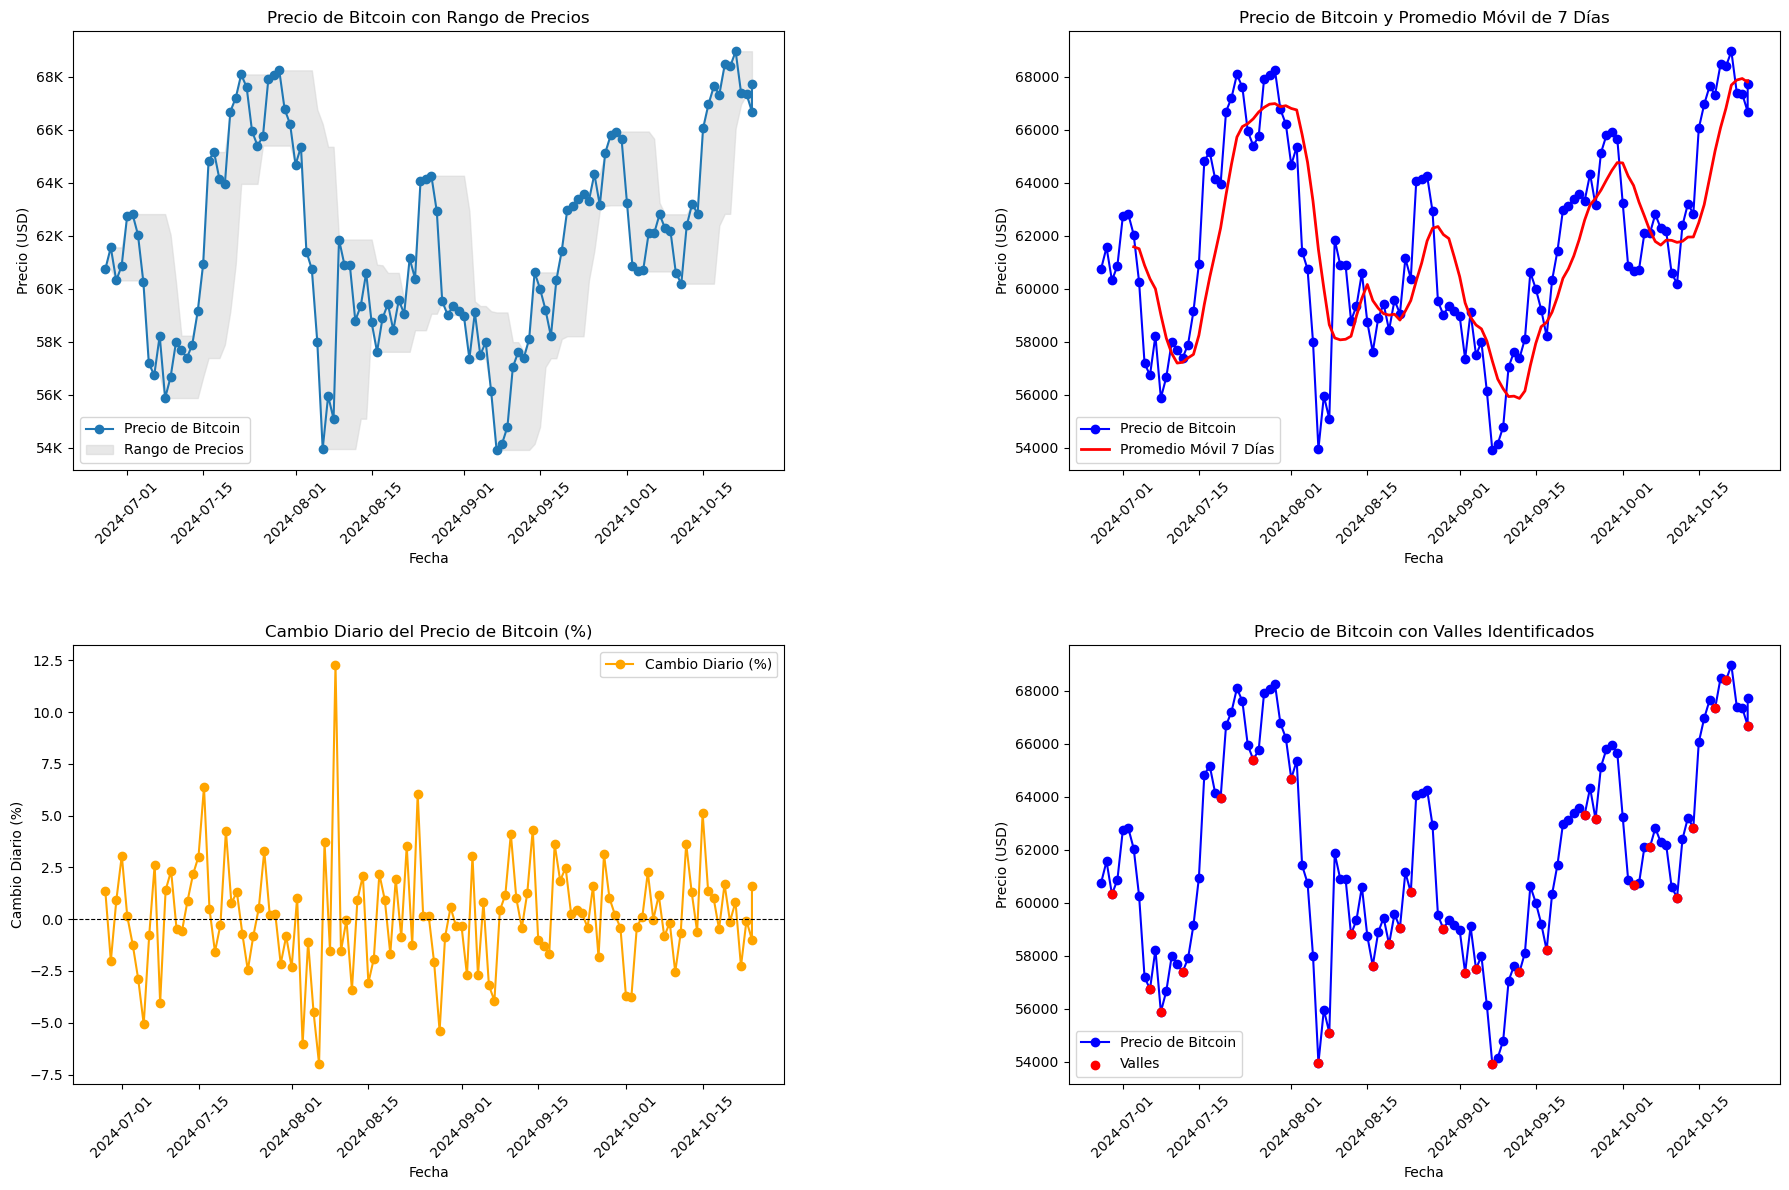

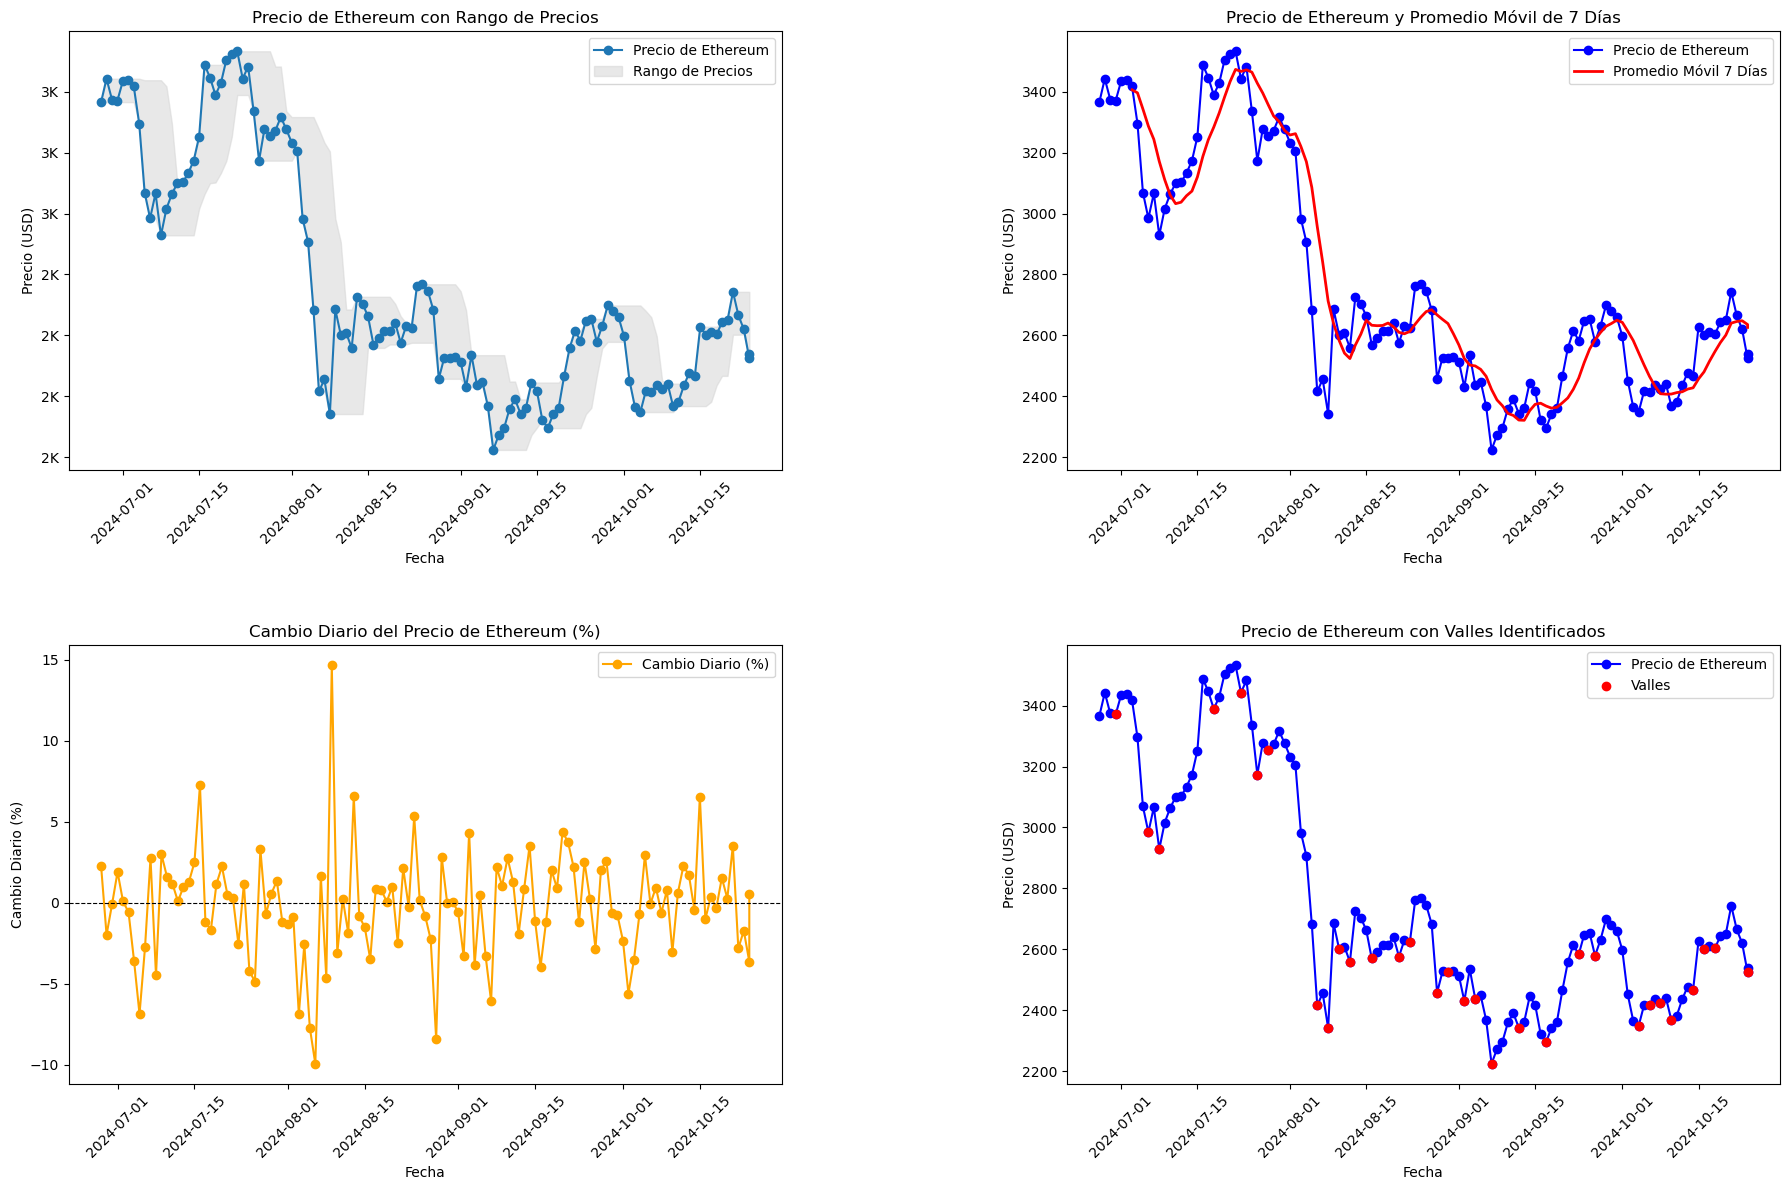

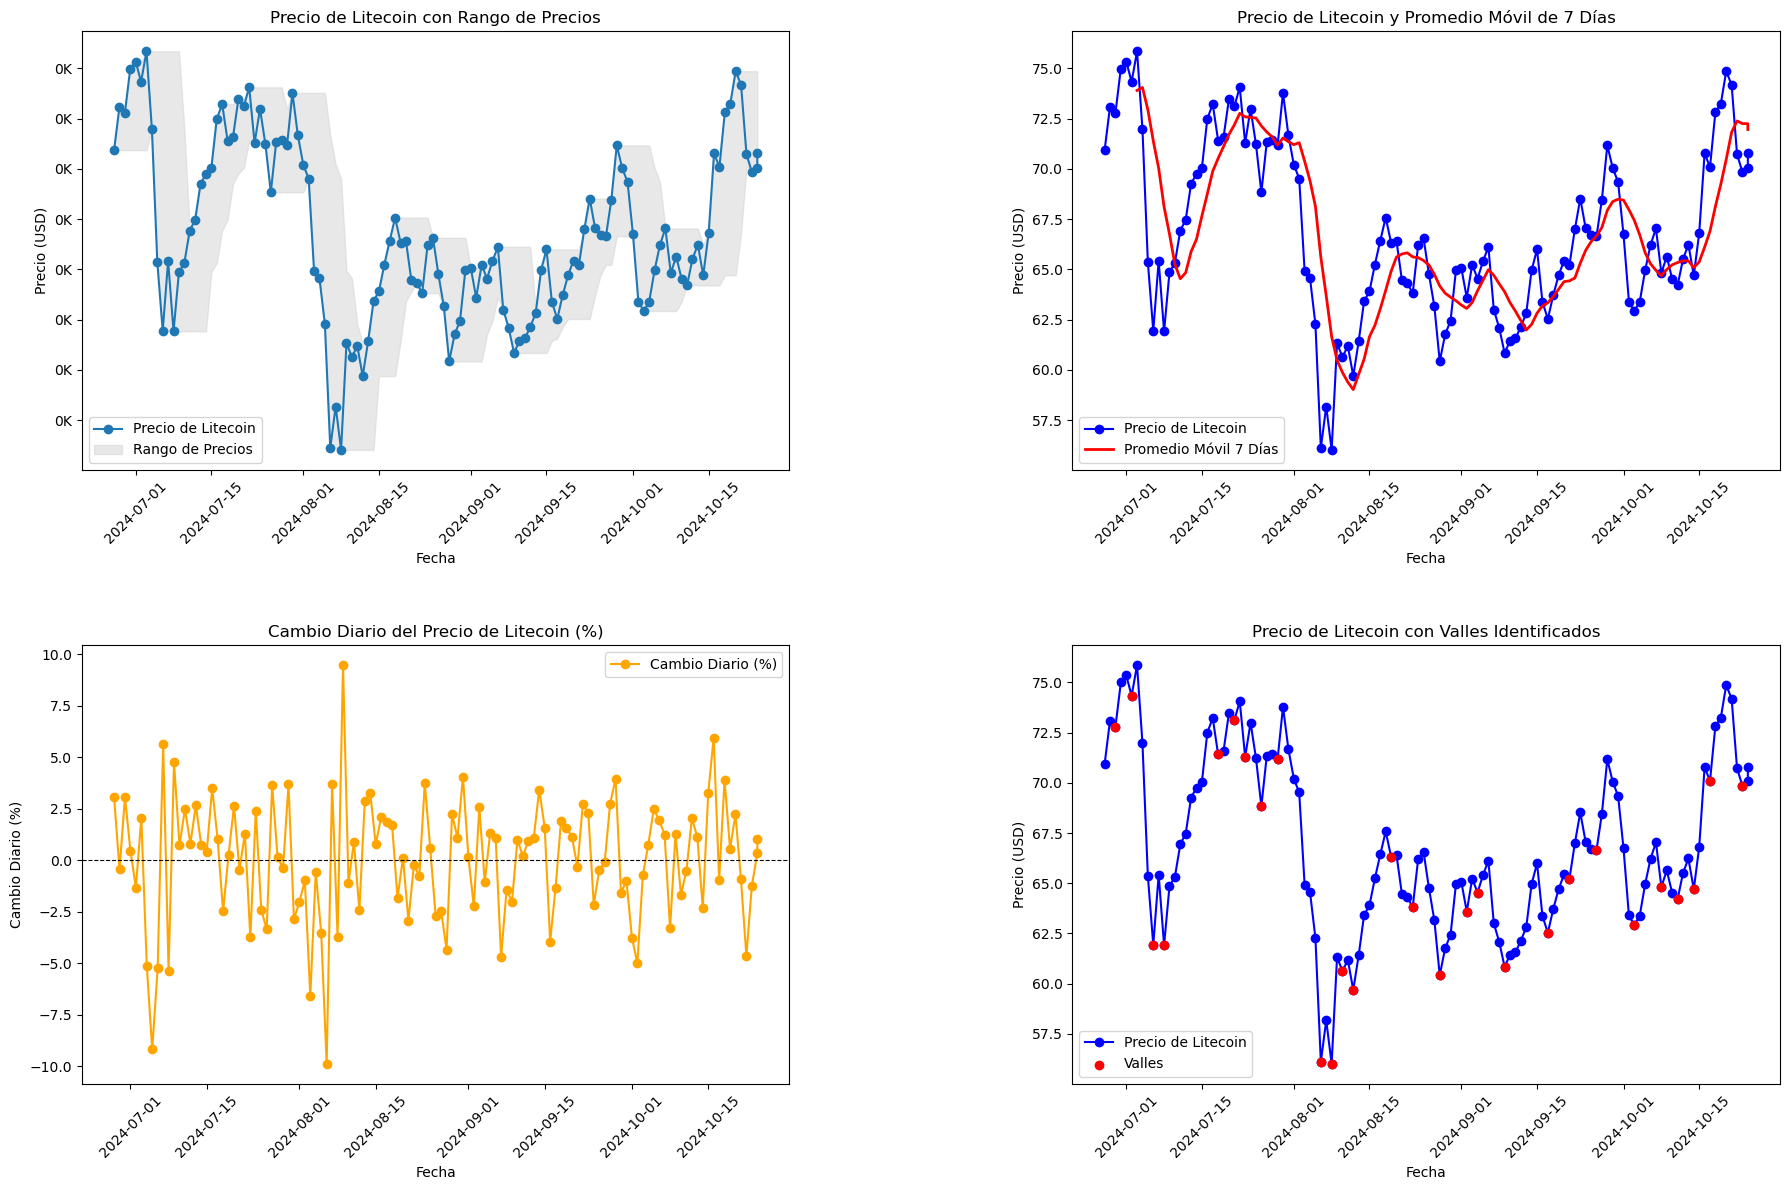

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker

# Asegúrate de que 'date' está en formato datetime
final_df['date'] = pd.to_datetime(final_df['date'])

# Obtener una lista única de criptomonedas
cryptos = final_df['crypto'].unique()

# Crear un gráfico para cada criptomoneda
for crypto in cryptos:
    # Filtrar los datos para la criptomoneda actual
    crypto_df = final_df[final_df['crypto'] == crypto]

    # Calcular el rango de precios
    min_price = crypto_df['price'].min()
    max_price = crypto_df['price'].max()

    # Calcular límites del eje Y con un margen del 5%
    margin = (max_price - min_price) * 0.05  # 5% de margen
    y_lower = min_price - margin
    y_upper = max_price + margin

    # Crear la figura y los ejes (2 filas, 2 columnas)
    fig, axs = plt.subplots(2, 2, figsize=(18, 12))

    # Gráfico 1: Precio de la Cripto con Rango de Precios (Posición 1)
    axs[0, 0].plot(crypto_df['date'], crypto_df['price'], label=f'Precio de {crypto}', marker='o')
    axs[0, 0].fill_between(crypto_df['date'], crypto_df['min_price_value'], crypto_df['max_price_value'], color='lightgrey', alpha=0.5, label='Rango de Precios')
    axs[0, 0].set_title(f'Precio de {crypto} con Rango de Precios')
    axs[0, 0].set_xlabel('Fecha')
    axs[0, 0].set_ylabel('Precio (USD)')
    axs[0, 0].set_ylim(y_lower, y_upper)
    axs[0, 0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x / 1000)}K'))
    axs[0, 0].tick_params(axis='x', rotation=45)
    axs[0, 0].legend()

    # Gráfico 2: Promedio Móvil de 7 días (Posición 2)
    axs[0, 1].plot(crypto_df['date'], crypto_df['price'], color='blue', label=f'Precio de {crypto}', marker='o')
    axs[0, 1].plot(crypto_df['date'], crypto_df['moving_average_7'], color='red', label='Promedio Móvil 7 Días', linewidth=2)
    axs[0, 1].set_title(f'Precio de {crypto} y Promedio Móvil de 7 Días')
    axs[0, 1].set_xlabel('Fecha')
    axs[0, 1].set_ylabel('Precio (USD)')
    axs[0, 1].tick_params(axis='x', rotation=45)
    axs[0, 1].legend()

    # Gráfico 3: Cambio Diario (Posición 3)
    axs[1, 0].plot(crypto_df['date'], crypto_df['daily_change'], color='orange', marker='o', label='Cambio Diario (%)')
    axs[1, 0].axhline(0, color='black', linewidth=0.8, linestyle='--')
    axs[1, 0].set_title(f'Cambio Diario del Precio de {crypto} (%)')
    axs[1, 0].set_xlabel('Fecha')
    axs[1, 0].set_ylabel('Cambio Diario (%)')
    axs[1, 0].tick_params(axis='x', rotation=45)
    axs[1, 0].legend()

    # Gráfico 4: Valles en el Precio de la Cripto (Posición 4)
    valleys_crypto_df = crypto_df[crypto_df['valley'] == 1]  # Filtrar para obtener solo los valles
    axs[1, 1].plot(crypto_df['date'], crypto_df['price'], color='blue', label=f'Precio de {crypto}', marker='o')
    axs[1, 1].scatter(valleys_crypto_df['date'], valleys_crypto_df['price'], color='red', label='Valles', zorder=5)
    axs[1, 1].set_title(f'Precio de {crypto} con Valles Identificados')
    axs[1, 1].set_xlabel('Fecha')
    axs[1, 1].set_ylabel('Precio (USD)')
    axs[1, 1].tick_params(axis='x', rotation=45)
    axs[1, 1].legend()

    # Ajustar el espaciado entre gráficos
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4, wspace=0.4)

    # Mostrar los gráficos
    plt.show()
